In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
user_pv = pd.DataFrame.from_csv('user_post_votes.csv', index_col=None)
user_pv.head(10)

,UserId,UserViews,UserReputation,PostId,PostType,VoteType,PostCreation,VoteCreation
0,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2011-11-15T00:00:00.000
1,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2011-11-15T00:00:00.000
2,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2011-11-16T00:00:00.000
3,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2011-11-16T00:00:00.000
4,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2011-11-16T00:00:00.000
5,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2011-11-22T00:00:00.000
6,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2011-11-28T00:00:00.000
7,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2011-12-13T00:00:00.000
8,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2012-01-30T00:00:00.000
9,3,44,1317,1,1,2,2011-11-15T20:45:51.037,2012-04-20T00:00:00.000


In [3]:
user_pv = user_pv.dropna()

In [4]:
user_pv[(user_pv.VoteCreation.isnull()) | (user_pv.PostCreation.isnull())]

,UserId,UserViews,UserReputation,PostId,PostType,VoteType,PostCreation,VoteCreation


In [5]:
user_pv[((user_pv.PostType!=1) & (user_pv.PostType!=2)) | (user_pv.PostId).isnull()]

,UserId,UserViews,UserReputation,PostId,PostType,VoteType,PostCreation,VoteCreation


In [6]:
def do_rename(se,new_name):
    se.name = new_name
    return se

def post_counts(df,p_typeid=1):
    def diff_counts(df_l):
        by_post = df_l.sort_values(by=["PostCreation"])[["UserId","PostId"]]
        first_occurences = by_post.sort_values(by=["PostId"]).drop_duplicates().groupby('UserId').cumcount() + 1
        return first_occurences.reindex(df_l.index).ffill()
    if p_typeid == 2:
        colname = "AnsContributed"
    if not (df.PostType==p_typeid).any():
        return pd.Series([0 for e in range(df.shape[0])],index=df.index)
    by_post_order = diff_counts(df[df.PostType==p_typeid][['UserId','PostCreation','PostId']])
    by_vote = by_post_order.reindex(df.index)
    by_vote[by_vote<=by_vote.shift(1)]=np.nan
    return by_vote.ffill().fillna(0)

predictors_tseries = ["PostId","PostType","QContributed","AnsContributed","ScoreRcvQ","VotRcvQ","ScoreRcvAns","VotRcvAns","Age"]
get_cols = lambda df : [df.PostId,df.PostType,post_counts(df), post_counts(df,p_typeid=2), ((df.PostType==1)&(df.VoteType==2)).cumsum()-((df.PostType==1)&(df.VoteType==3)).cumsum(),
                        ((df.PostType==1)&(df.VoteType.notnull())).cumsum(),((df.PostType==2)&(df.VoteType==2)).cumsum()-((df.PostType==2)&(df.VoteType==3)).cumsum(),
                       ((df.PostType==2)&(df.VoteType.notnull())).cumsum(),
                       (pd.to_datetime(df.VoteCreation,format='%Y-%m-%d %H:%M:%S.%f')
                  - pd.to_datetime(df.PostCreation,format='%Y-%m-%d %H:%M:%S.%f')).apply(lambda x: x.astype('timedelta64[D]').item().days) + 1]
        
ff1 = lambda df : pd.concat([do_rename(get_c,name) for name,get_c in zip(predictors_tseries,get_cols(df))],axis=1)
user_tseries = user_pv.sort_values(by=["VoteCreation"]).groupby(['UserId']).apply(ff1).reset_index(level=[0],drop=True)

In [7]:
user_tseries.head(20)

,PostId,PostType,QContributed,AnsContributed,ScoreRcvQ,VotRcvQ,ScoreRcvAns,VotRcvAns,Age
0,1,1,1,0,1,1,0,0,0
1,55,2,0,1,0,0,1,1,0
2,55,2,0,1,0,0,2,2,0
3,55,2,0,1,0,0,3,3,0
4,55,2,0,1,0,0,4,4,0
5,55,2,0,1,0,0,5,5,0
6,55,2,0,1,0,0,6,6,0
7,55,2,0,1,0,0,7,7,0
8,55,2,0,1,0,0,8,8,0
9,55,2,0,1,0,0,9,9,0


In [8]:
user_tseries[(user_tseries.QContributed.isnull())| (user_tseries.AnsContributed.isnull())]

,PostId,PostType,QContributed,AnsContributed,ScoreRcvQ,VotRcvQ,ScoreRcvAns,VotRcvAns,Age


## Aggregate predictors Reputation against (Q-Ans)Contributions and votes on contributions

In [9]:
users = user_pv[['UserId','UserViews','UserReputation','PostId','PostType']]

In [11]:
predictors = ["Reputation","Views","QContributed","AnsContributed","VotesRcvQ","VotesRcvAns"]

pr_values = lambda df: [[df.UserReputation.iloc[0]],[df.UserViews.iloc[0]], [df[df.PostType==1]['PostId'].unique().size],
                        [df[df.PostType==2]['PostId'].unique().size], [sum(df.PostType==1)], [sum(df.PostType==2)]]
ff2 = lambda df : pd.DataFrame(data=dict(zip(predictors,pr_values(df))))
users = users.groupby(['UserId']).apply(ff2).reset_index(level=[1],drop=True)
users.head(10)

,AnsContributed,QContributed,Reputation,Views,VotesRcvAns,VotesRcvQ
UserId,,,,,,
3,11,6,1317,44,90,60
5,1,2,205,5,4,12
6,0,6,460,11,0,69
8,3,0,226,6,11,0
9,1,0,111,0,1,0
10,7,1,708,25,56,12
12,54,98,6139,375,286,623
15,2,0,153,6,5,0
18,0,2,380,0,0,55


In [13]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [15]:
users.describe()

,AnsContributed,QContributed,Reputation,Views,VotesRcvAns,VotesRcvQ
count,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000
mean,3.358739,1.436103,221.128367,4.268195,12.946705,6.103152
std,13.146219,8.358479,705.941634,18.796387,54.159826,36.088556
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,99.000000,1.000000,2.000000,0.000000
75%,2.000000,1.000000,157.000000,2.000000,6.000000,4.000000
max,343.000000,258.000000,15418.000000,375.000000,1232.000000,1083.000000


                      0.5       0.75       0.85       0.95
Views           -0.402337  -0.488480  -0.600216  -0.556296
AnsContributed   3.269158   2.849469   2.494576   1.946492
QContributed     2.418061   1.662115   1.596646   2.231474
VotesRcvAns     11.249964  11.366951  11.471335  11.554406
VotesRcvQ        4.729339   4.864317   4.854752   4.635805


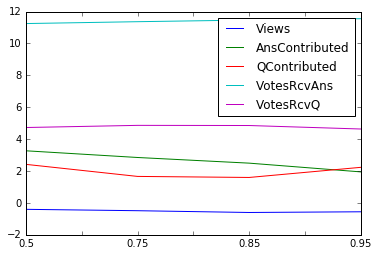

In [16]:

fml = 'Reputation ~ Views + AnsContributed + QContributed + VotesRcvAns + VotesRcvQ - 1'
mat_1 = []
r2s_1 = []
pcnt = [.5,.75, .85, .95]
quantiles = [e for e in users.Reputation.quantile(pcnt)]
for q in quantiles:
    mod = sm.OLS.from_formula(fml, users[users.Reputation>=q])
    rslt = mod.fit()
    mat_1.append(rslt.params)
    r2s_1.append(rslt.rsquared)
mat_1 = pd.DataFrame(mat_1, index=[str(x) for x in pcnt])
print mat_1.T
mat_1.plot()

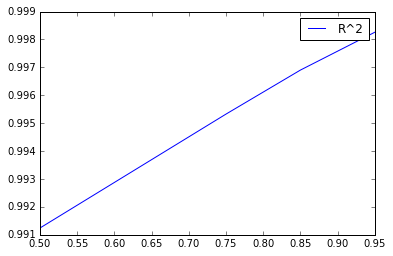

In [17]:
plt.plot(pcnt,r2s_1,label='R^2')
plt.legend(loc='upper right')
plt.show()

In [6]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
 
pandas2ri.activate()
rdf = pandas2ri.py2ri_pandasdataframe(users[users.Reputation>=210])
qpoisson = ro.r.glm('Reputation ~ Age + Vehicle_Use', data = rdf, family = ro.r('quasipoisson(link = &quot;log&quot;)'))
print ro.r.summary(qpoisson)

RuntimeError: R_HOME not defined.

In [18]:
user_tseries.drop(user_tseries.columns[[1]], axis=1, inplace=True) #drop PostType
user_tseries=user_tseries.rename(columns = {'PostId':'AnsId'})
user_tseries

,AnsId,QContributed,AnsContributed,ScoreRcvQ,VotRcvQ,ScoreRcvAns,VotRcvAns,Age
0,1,1,0,1,1,0,0,0
1,55,0,1,0,0,1,1,0
2,55,0,1,0,0,2,2,0
3,55,0,1,0,0,3,3,0
4,55,0,1,0,0,4,4,0
5,55,0,1,0,0,5,5,0
6,55,0,1,0,0,6,6,0
7,55,0,1,0,0,7,7,0
8,55,0,1,0,0,8,8,0
9,55,0,1,0,0,9,9,0


In [19]:
user_tseries.to_csv(path_or_buf='user_reputation_votes.csv')